In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Tue Apr 23 20:29:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

In [ ]:
import os
import time
import glob
import shutil

# import data handling tools
import cv2
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow.image as tfi
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import load_img,img_to_array
from tensorflow.keras.layers import Conv2D,  MaxPool2D, UpSampling2D, concatenate, Activation
from tensorflow.keras.layers import Layer, Input, Add, Multiply, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
def create_data(data_dir):
    image_paths = []
    mask_paths = []

    folds = sorted(os.listdir(data_dir))
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        if fold in ['image', 'Image', 'images', 'Images', 'IMAGES']:
            images = sorted(os.listdir(foldpath))
            for image in images:
                fpath = os.path.join(foldpath, image)
                image_paths.append(fpath)

        elif fold in ['mask', 'Mask', 'masks', 'Masks', 'MASKS']:
            masks = sorted(os.listdir(foldpath))
            for mask in masks:
                fpath = os.path.join(foldpath, mask)
                mask_paths.append(fpath)
        else:
            continue

    return image_paths, mask_paths

In [ ]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image)) / 255., (SIZE, SIZE)), 4)

# function to read multiple images
def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img

    return images

In [ ]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')
    


def show_images(imgs, msks):
    plt.figure(figsize=(13,8))

    for i in range(15):
        plt.subplot(3,5,i+1)
        id = np.random.randint(len(imgs))
        show_mask(imgs[id], msks[id], cmap='binary')

    plt.tight_layout()
    plt.show()

ENCODER

In [ ]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

DECODER

In [ ]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }


ATTENTION GATE

In [ ]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

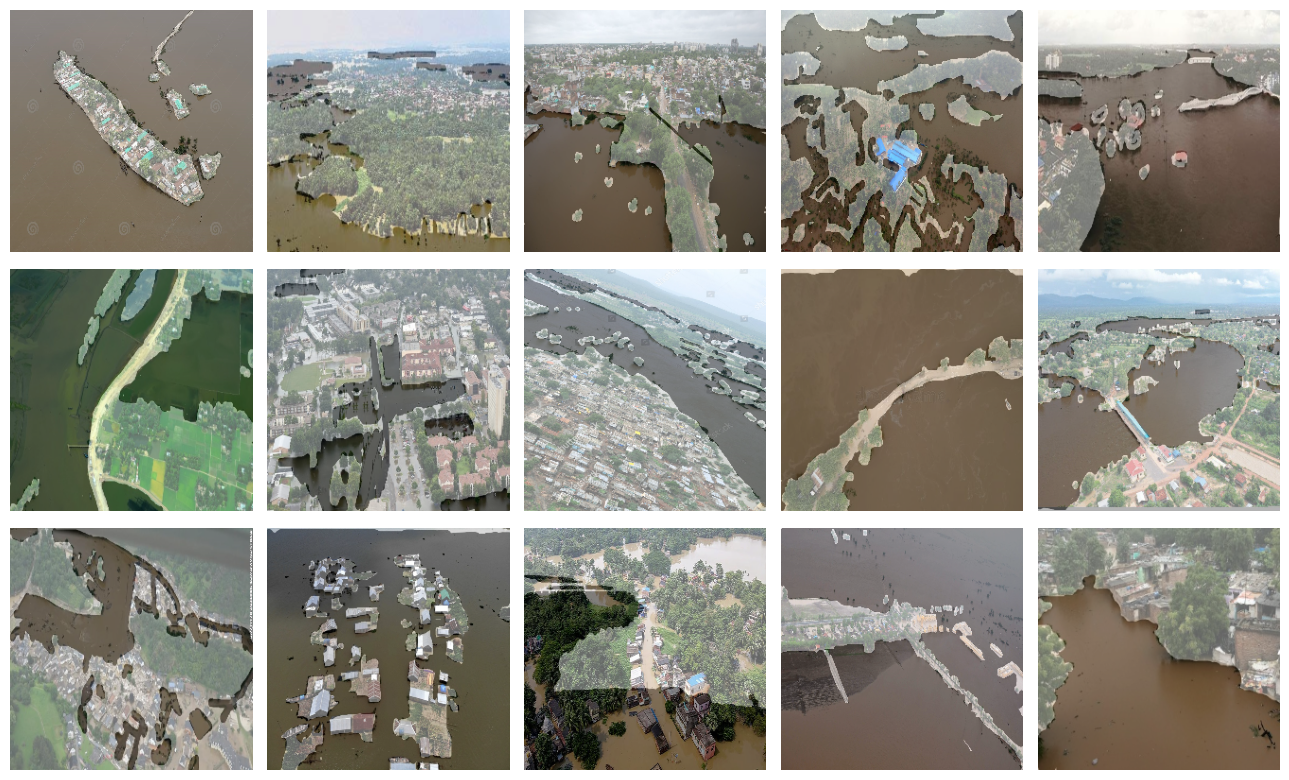

In [ ]:
SIZE = 256

# get data
data_dir = '/content/drive/MyDrive/data_flood_mapping'
image_paths, mask_paths = create_data(data_dir)

# load images and masks
imgs = load_images(image_paths, SIZE)
msks = load_images(mask_paths, SIZE, mask=True)

# show sample
show_images(imgs, msks)

In [ ]:
# Inputs
input_layer = Input(shape= imgs.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32, 0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64, 0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128, 0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256, 0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512, 0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder
a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256, 0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128, 0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64, 0.1, name="Decoder3")([d2, a3])

a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(inputs= [input_layer], outputs= [output_layer])

# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Encoder1 (EncoderBlock)     ((None, 128, 128, 32),       10144     ['input_1[0][0]']             
                              (None, 256, 256, 32))                                               
                                                                                                  
 Encoder2 (EncoderBlock)     ((None, 64, 64, 64),         55424     ['Encoder1[0][0]']            
                              (None, 128, 128, 64))                                               
                                                                                              

In [ ]:
batch_size = 40     # set batch size for training
epochs = 100         # number of all epochs in training
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
callbacks =  keras.callbacks.CallbackList(model= model, epochs= epochs, ask_epoch= ask_epoch)

In [ ]:
SPE = len(imgs)//batch_size

# Training
history = model.fit(
    imgs, msks,
    validation_split=0.2,
    epochs=epochs,
    verbose=1,
    steps_per_epoch=SPE,
    batch_size=batch_size
)

Epoch 1/100
7/7 [==============================] - 108s 8s/step - loss: 1.0328 - accuracy: 0.5856 - val_loss: 0.6892 - val_accuracy: 0.4414
Epoch 2/100
7/7 [==============================] - 9s 1s/step - loss: 0.5125 - accuracy: 0.7357 - val_loss: 0.7021 - val_accuracy: 0.3909
Epoch 3/100
7/7 [==============================] - 9s 1s/step - loss: 0.4724 - accuracy: 0.7791 - val_loss: 0.6505 - val_accuracy: 0.6643
Epoch 4/100
7/7 [==============================] - 9s 1s/step - loss: 0.4365 - accuracy: 0.7909 - val_loss: 0.6511 - val_accuracy: 0.6023
Epoch 5/100
7/7 [==============================] - 9s 1s/step - loss: 0.4128 - accuracy: 0.8011 - val_loss: 0.6616 - val_accuracy: 0.5701
Epoch 6/100
7/7 [==============================] - 9s 1s/step - loss: 0.4053 - accuracy: 0.8084 - val_loss: 0.6558 - val_accuracy: 0.5823
Epoch 7/100
7/7 [==============================] - 9s 1s/step - loss: 0.3782 - accuracy: 0.8227 - val_loss: 0.6415 - val_accuracy: 0.6252
Epoch 8/100
7/7 [===============

7/7 [==============================] - 7s 920ms/step - loss: 0.1651 - accuracy: 0.9176 - val_loss: 0.4758 - val_accuracy: 0.8408


1/1 [==============================] - 0s 19ms/step


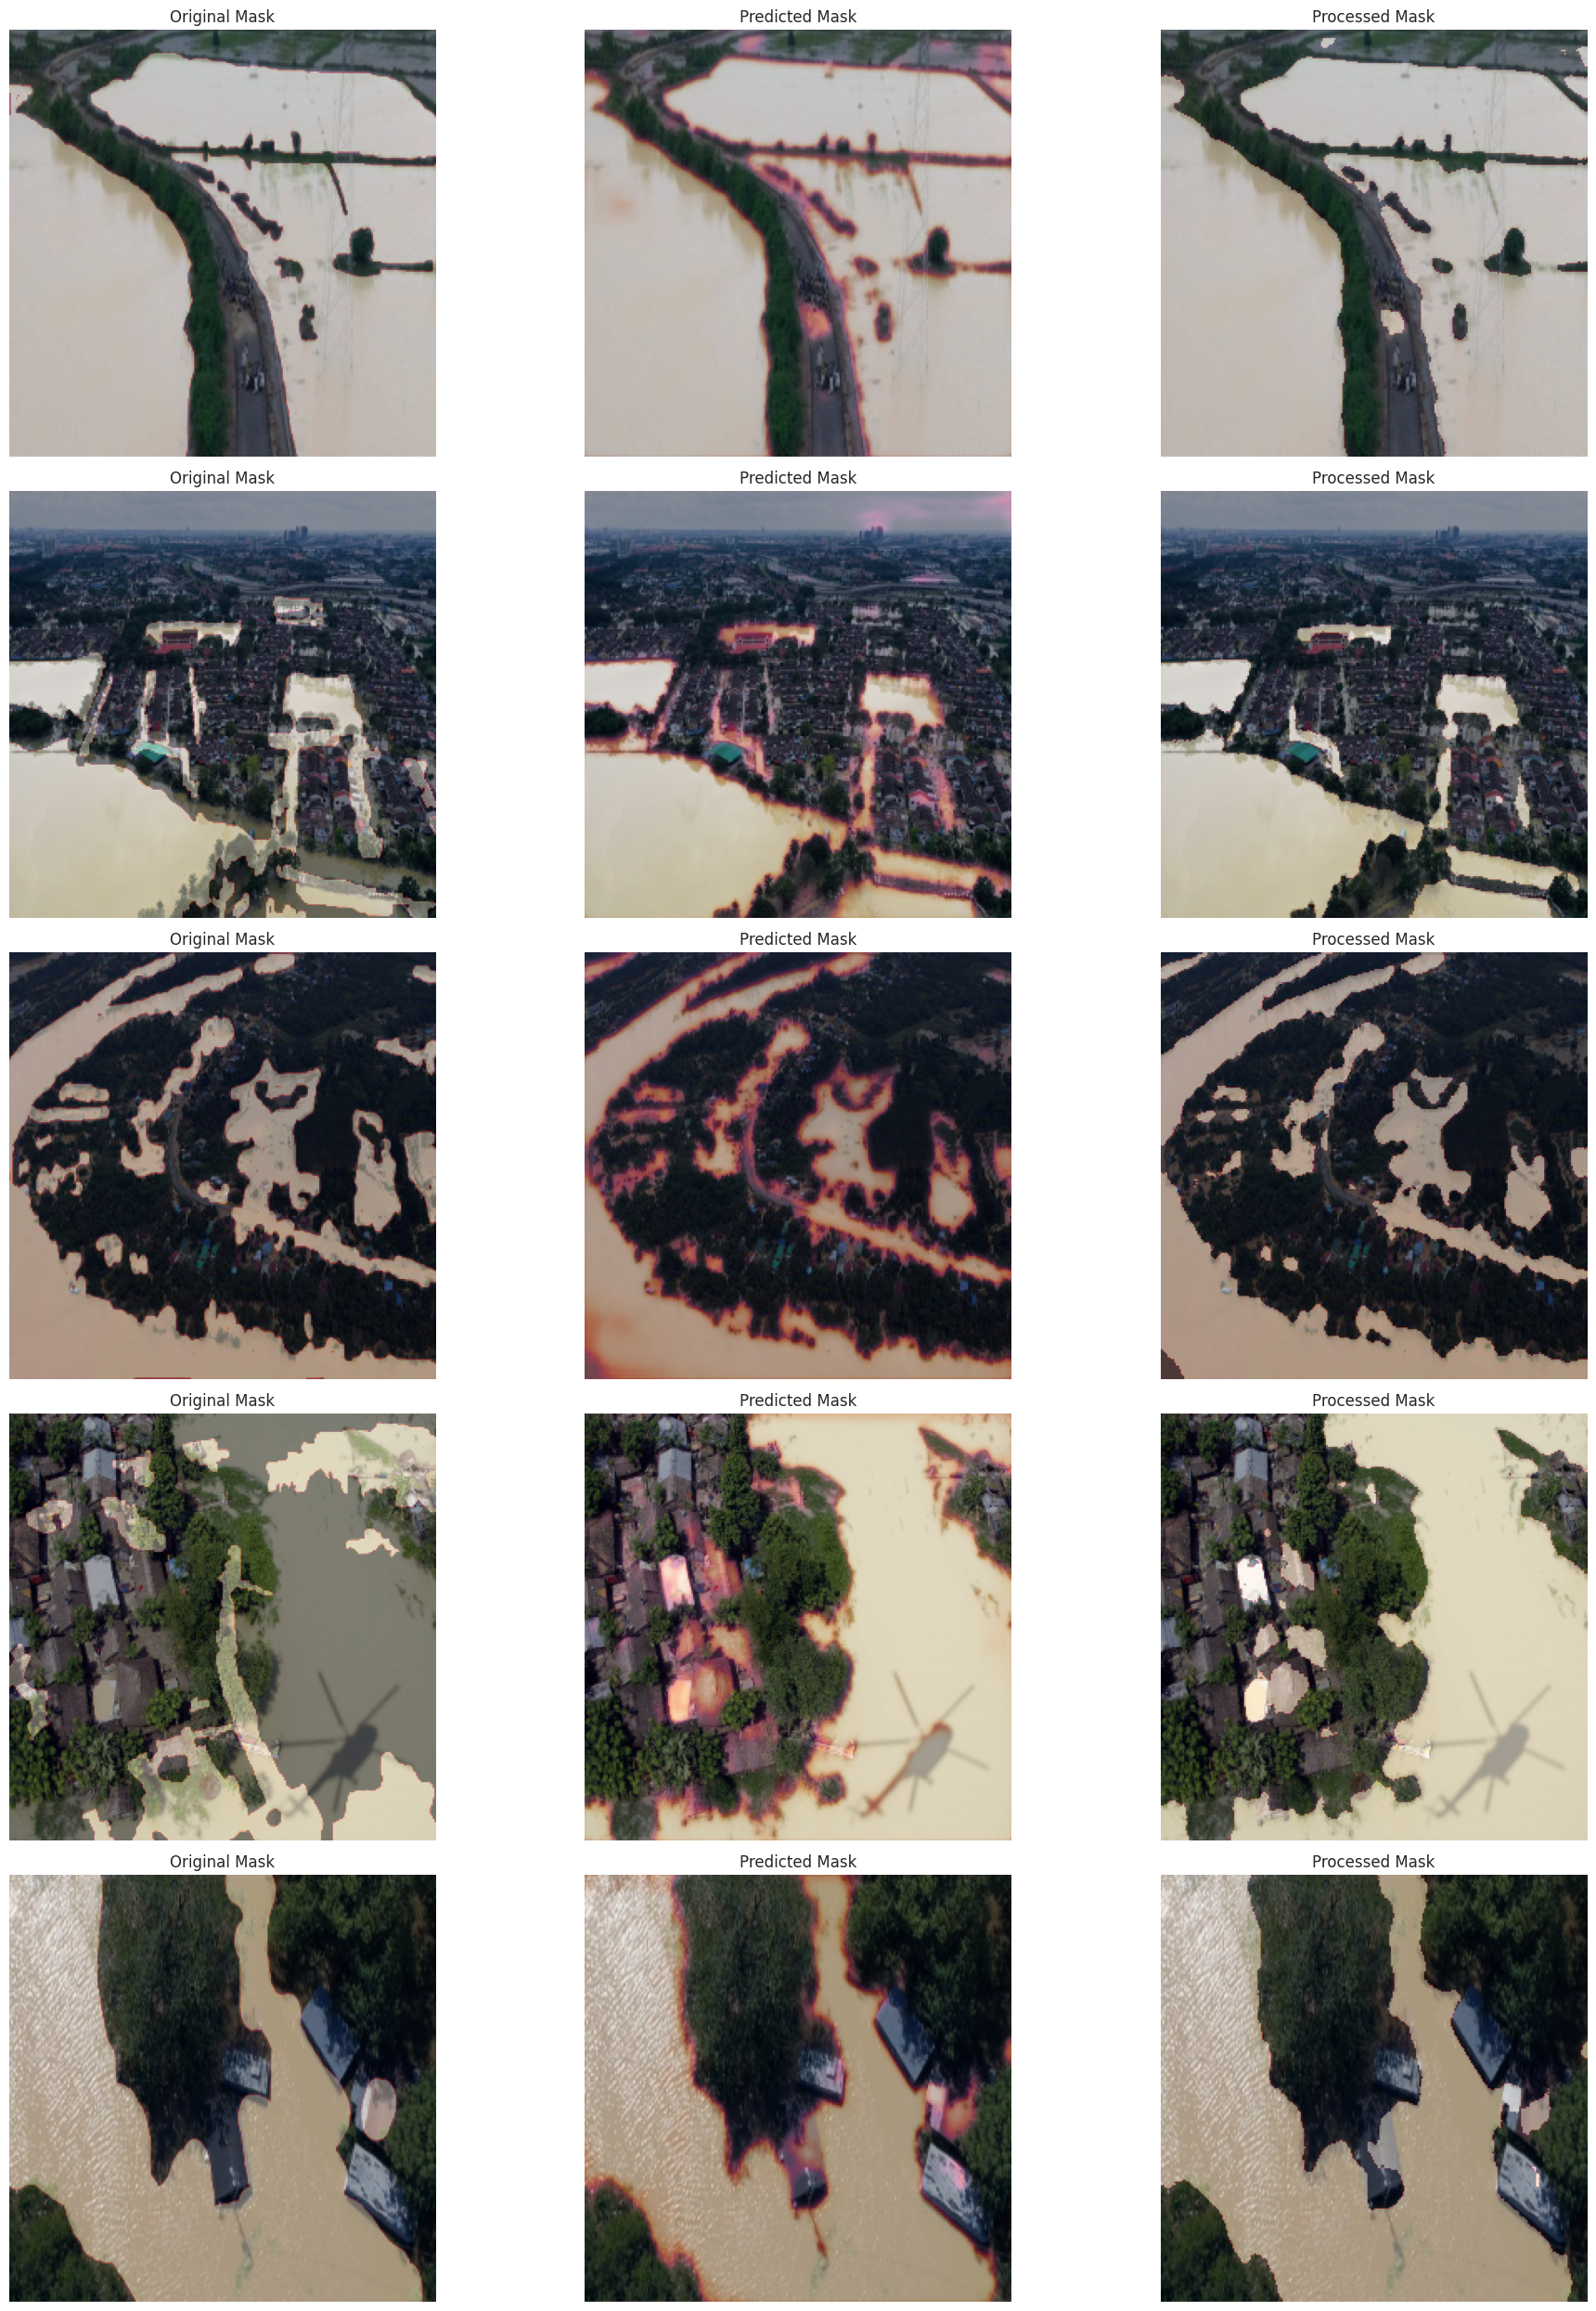

In [ ]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(imgs))
        image = imgs[id]
        mask = msks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

In [ ]:
image="/content/2.png"
img=load_image(image, SIZE)

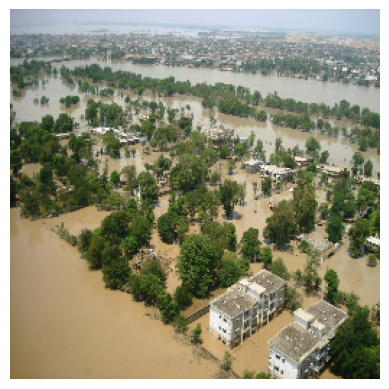

In [ ]:
show_image(img)

In [ ]:

pred_mask=model.predict(img[np.newaxis,...])

1/1 [==============================] - 0s 25ms/step


In [ ]:
pred_mask

array([[[[0.26861653],
         [0.21226007],
         [0.22648981],
         ...,
         [0.22373553],
         [0.30906814],
         [0.33539614]],

        [[0.1831808 ],
         [0.14903279],
         [0.18405148],
         ...,
         [0.16577838],
         [0.20780028],
         [0.24588585]],

        [[0.15418217],
         [0.14800848],
         [0.22503866],
         ...,
         [0.17990346],
         [0.25901395],
         [0.2017259 ]],

        ...,

        [[0.7948899 ],
         [0.8742254 ],
         [0.91562206],
         ...,
         [0.00708052],
         [0.01294582],
         [0.04032484]],

        [[0.7432741 ],
         [0.8122438 ],
         [0.8550394 ],
         ...,
         [0.01110231],
         [0.0203253 ],
         [0.06639417]],

        [[0.59902775],
         [0.72127146],
         [0.80490535],
         ...,
         [0.04503132],
         [0.07745422],
         [0.18930854]]]], dtype=float32)

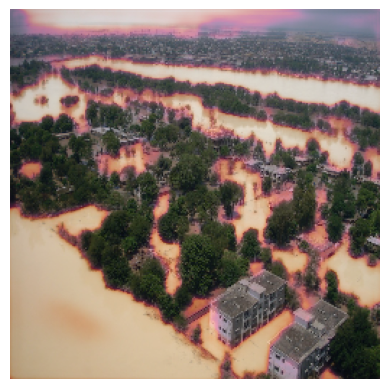

In [ ]:
show_mask(img,pred_mask)

In [ ]:
model.save('flood_mapping_unet.h5')